# Aktywne uczenie
Olga Krupa, Kinga Kwoka

## Treść zadania

**Temat projektu - 10**

Aktywne uczenie się modeli klasyfikacji na podstawie małych zbiorów trenujących przez zgłaszanie zapytania o prawdziwe wartości atrybutu docelowego dla ograniczonej liczby przykładów z dostarczonego dużego zbioru danych nieetykietowanych wybranych według określonych kryteriów (np. przykłady bliskie granicy decyzyjnej dotychczasowego modelu lub takie, dla których jego predykcje są obarczone największą niepewnością) i iteracyjne doskonalenie modelu na podstawie powiększanego w ten sposób zbioru trenującego. Implementacja w formie opakowania umożliwiającego użycie dowolnego algorytmu klasyfikacji dostępnego w środowisku R lub Python stosującego standardowy interfejs wywołania. Badanie wpływu użycia aktywnego uczenia się na jakość modeli klasyfikacji tworzonych na podstawie małych zbiorów trenujących za pomocą wybranych algorytmów dostępnych w środowisku R lub Python.

### Scenariusz aktywnego uczenia


Dla wybranego klasyfikatora:

1. Wybór losowy zestawu początkowych przykładów treningowych T z puli P.
2. Aktualizacja puli P poprzez usunięcie przykładów ze zbioru T.
3. Uzyskanie etykiet klas dla przykładów z T.
4. Powtarzanie poniższego procesu do momentu osiągnięcia maksymalnej liczby iteracji,
spełnienia kryteriów stopu lub wyczerpania puli P:

  *   Tworzenie modelu klasyfikacji m na podstawie zbioru T.
  *   Wybór zbioru przykładów Q do zapytania ze zbioru P na podstawie wybranej
  metody i odpowiedzi modelu m.
  *   Uzyskanie etykiet klas dla przykładów z Q.
  *   Uaktualnienie zbioru T poprzez dodanie przykładów z Q. Aktualizacja zbioru P poprzez usunięcie przykładów Q.

5. Zwrócenie modelu klasyfikacji m.

### Wykorzystane metody selekcji próbek



*   random_sampling - losowy wybór próbek (równoważne niezastosowaniu aktywnego ucznia)
*   uncertainty_sampling - wybór próbek, dla których model jest najmniej pewny swoich predykcji.
*   kmeans_plus_plus_sampling - wykorzystanie algorytmu kmeans++
*   diversity_sampling - wybór próbek, najbardziej różniących się w stosunku do tych, które już znajdują się w zbiorze treningowym (na podstawie odległości euklidesowej między parami)




### Metryki



*   Dokładność
*   Precyzja
*   Odzysk
*   F1
*   Pole pod krzywą ROC
*   Pole pod krzywą PR



### Eksperymenty


W ramach proejktu zostały wybrane 3 algorytmy klasyfikacji:


*   Drzewa decyzyjne
*   K-najbliższych sąsiadów
*   Klasyfikator SVM

Każdy z algorytmów został przetestowany na różnych zbiorach, odpowiednio:


*   Cover Type
*   Wine quality
*   Sztucznie wygenerowany zbiór (sklearn.datasets.make_classification)

Eksperymenty obejmowały porównanie zaproponowanego rozszerzenia z dostępną biblioteką modAL oraz porównanie metryk dla różnych metod selekcji próbek.





## Środowisko wykonawcze

In [1]:
!pip install modAL-python
!pip install ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.9 MB/s eta 0:00:00


In [2]:
%%bash
git clone https://github.com/kzkwoka/active_learning_module.git
cd active_learning_module
git checkout dev

Branch 'dev' set up to track remote branch 'dev' from 'origin'.


Cloning into 'active_learning_module'...
Switched to a new branch 'dev'


In [3]:
%cd active_learning_module

/content/active_learning_module


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

from src.active import ActiveModule
from src.strategies import *
from src.utils import *

## Cover Type / Drzewo decyzyjne

Zbiór Covertype obejmuje ponad 500 tys. instancji, z których należy wyznaczyć 7 typów pokrycia leśnego na podstawie atrybutów, takich jak wysokość, aspekt, nachylenie, cień wzgórza, typ gleby i inne.

### Zbiór danych

In [40]:
# fetch dataset
dataset = fetch_ucirepo(id=31) # id=31 (covertype), 144(), 186 (wine quality)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

if dataset.metadata.uci_id == 31:
    _, X, _, y = train_test_split(X, y, test_size=0.1, random_state=42)

n_classes = y.nunique().iloc[0]

### Wstępne przetwarzanie

In [41]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [43]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [44]:
t = DecisionTreeClassifier(random_state=42)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [45]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [46]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.83, 'roc_auc': 0.855, 'pr_auc': 0.599}

### Aktywne uczenie

In [47]:
learner = ActiveModule(estimator=DecisionTreeClassifier,
                       X=X_train,
                       y_initial=y_train.values[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test.values,
                       random_state=42,)

In [48]:
n_samples = 1000
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [49]:
metrics, info = run_experiments(learner, y_train.values, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling], n_samples, n_iter)  #1min 14s  kmeans_plus_plus_sampling

100%|██████████| 3/3 [04:53<00:00, 97.76s/it] 


In [50]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.72s
One training loop with uncertainty_sampling takes approx. 0.63s
One training loop with kmeans_plus_plus_sampling takes approx. 5.64s


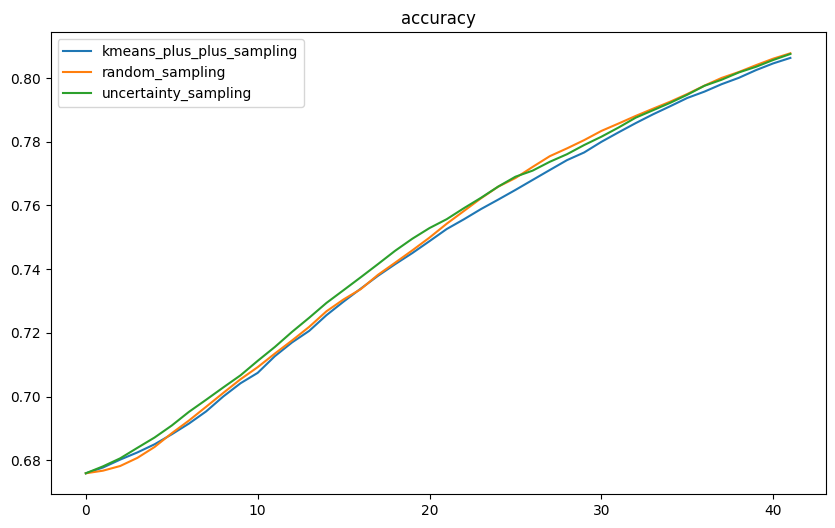

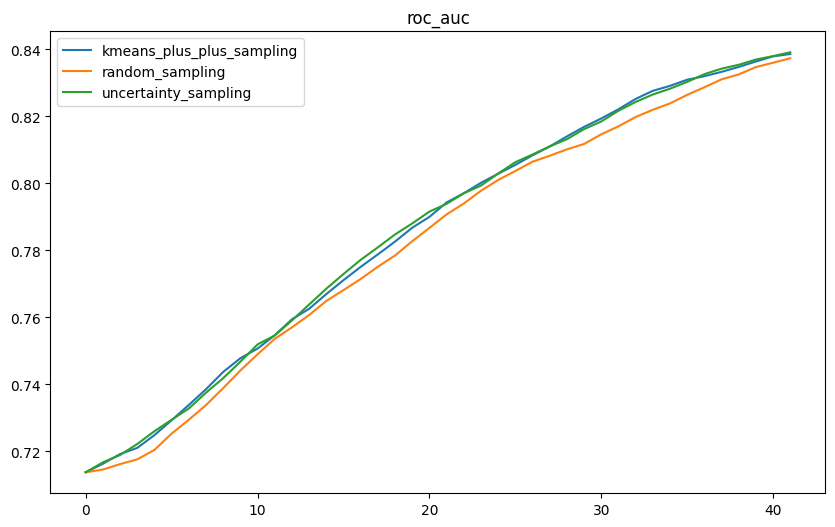

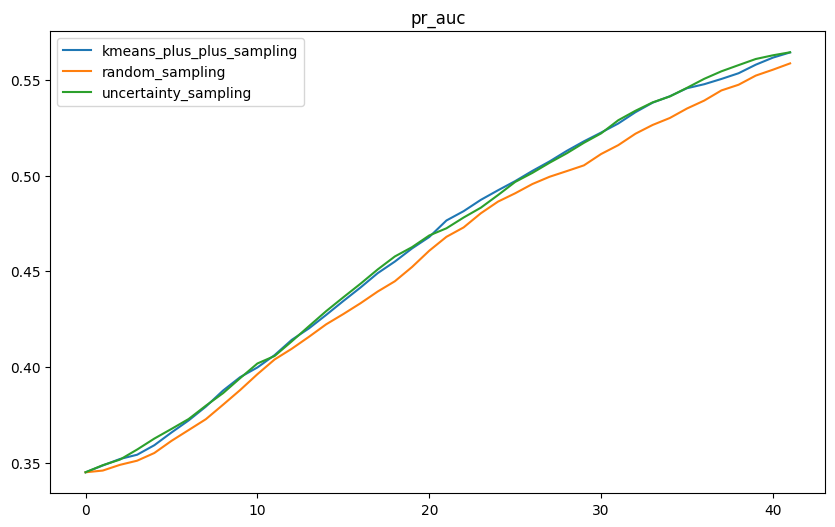

In [54]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.9), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Aktywne uczenie z biblioteką modAL

In [23]:
import modAL
from modAL.models import ActiveLearner

In [24]:
mlearner = ActiveLearner(
    estimator=DecisionTreeClassifier(random_state=42),
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train[initial_idx], y_training=y_train.values[initial_idx]
)
X_to_train = X_train.copy()
y_to_train = y_train.values.copy()
modAL_metrics = []

query_idx = initial_idx

for i in (t:= tqdm(range(n_iter))):
    mlearner.teach(X_to_train[query_idx], y_to_train[query_idx])

    X_to_train = np.delete(X_to_train, query_idx, axis=0)
    y_to_train = np.delete(y_to_train, query_idx, axis=0)
    y_pred = mlearner.predict(X_test)
    matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
    modAL_metrics.append({
        'default_metric': mlearner.score(X_test, y_test),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(matrix, matrix_pred),
        'pr_auc': average_precision_score(matrix, matrix_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })
    query_idx, query_inst = mlearner.query(X_to_train, n_instances=n_samples)

avg_loop_time = t.format_dict['elapsed']/ t.format_dict['total']
modAL_metrics = pd.DataFrame(modAL_metrics)
# modAL_metrics[["accuracy", "pr_auc", "roc_auc"]].plot()
# print(learner.score(X_test, y_test))

100%|██████████| 42/42 [00:44<00:00,  1.05s/it]


In [25]:
f"One training loop with uncertainty_sampling from modAL takes approx. {round(avg_loop_time, 2)}s"

'One training loop with uncertainty_sampling from modAL takes approx. 1.05s'

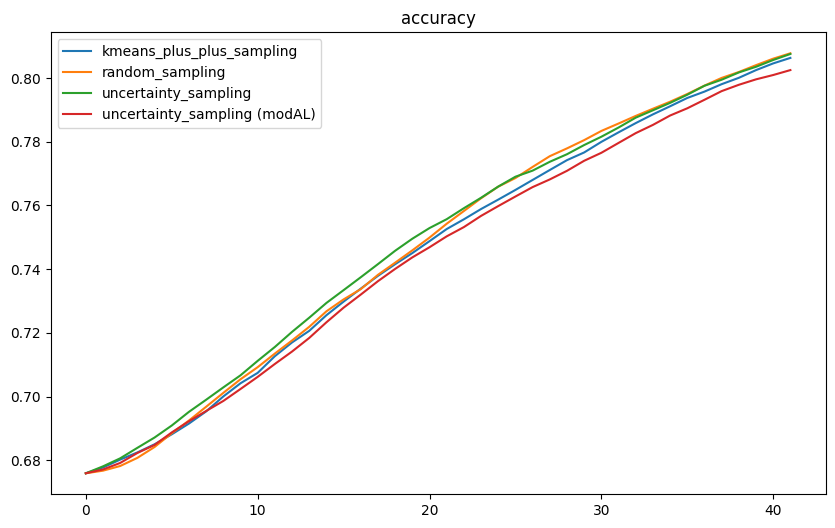

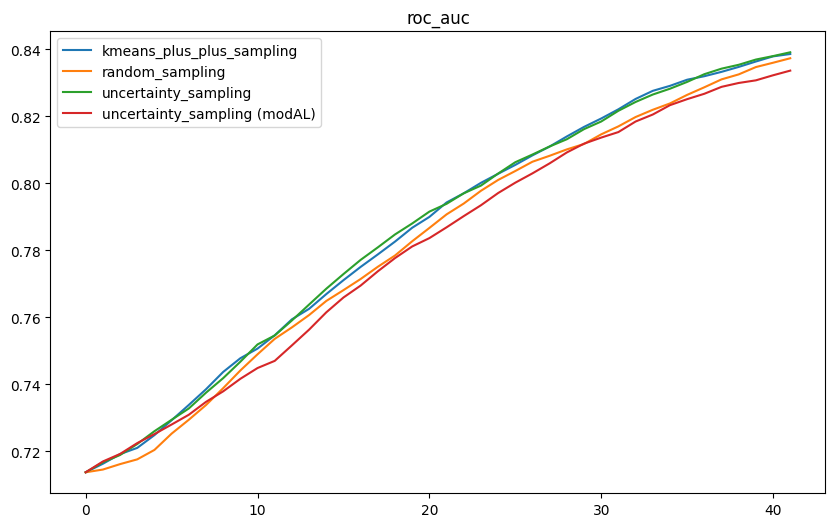

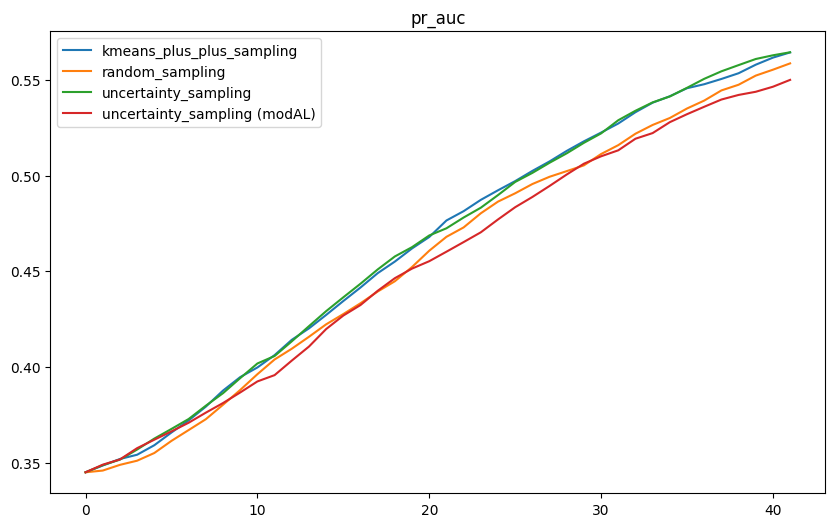

In [55]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.9), label=f'{strategy}')
    ax.plot(modAL_metrics.index, smooth(modAL_metrics[metric], 0.9), label=f'uncertainty_sampling (modAL)')
    plt.legend()
    plt.title(metric)
    plt.show()

### Wnioski

Dokładność dla wszytskich metod wyboru próbek osiągają podobną dokładność. Wynika to z dużej różnorodności liczby próbek dla danej klasy, a zatem dokładność dotyczy głównie największych klas. Różnice w wynikach można zaobserwować na wykresie pola pod krzywą ROC, gdzie wartość metryki wyliczana jest osobno dla każdej klasy (porównanie danej klasy do pozostałych próbek) i wtedy uśredniana. Szczególnie w początkowych iteracjach metody aktywnego uczenia pozwalają na szybszy wzrost dokładności predyckji. Podobne wnioski sugeruje wykres pola pod krzywą precyzji i odzysku.

## Wine quality / K-najbliższych sąsiadów

Zbiór Wine quality posiada 6497 próbek zawierające informacje o różnych właściwościach win.

### Zbiór danych

In [59]:
# fetch dataset
dataset = fetch_ucirepo(id=186) # id=31 (covertype), 144(), 186 (wine quality)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

if dataset.metadata.uci_id == 31:
    _, X, _, y = train_test_split(X, y, test_size=0.1, random_state=42)

n_classes = y.nunique().iloc[0]

### Wstępne przetwarzanie

In [60]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [62]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [63]:
t = KNeighborsClassifier(n_neighbors=n_classes)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [64]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [65]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.568, 'roc_auc': 0.582, 'pr_auc': 0.206}

### Aktywne uczenie

In [66]:
learner = ActiveModule(estimator=KNeighborsClassifier,
                       X=X_train,
                       y_initial=y_train.values[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test.values,
                       n_neighbors=n_classes,)

In [67]:
n_samples = 100
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [68]:
metrics, info = run_experiments(learner, y_train.values, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling, diversity_sampling], n_samples, n_iter)  #14 min  diversity_sampling

100%|██████████| 4/4 [19:57<00:00, 299.49s/it]


In [69]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.32s
One training loop with uncertainty_sampling takes approx. 0.8s
One training loop with kmeans_plus_plus_sampling takes approx. 0.51s
One training loop with diversity_sampling takes approx. 23.86s


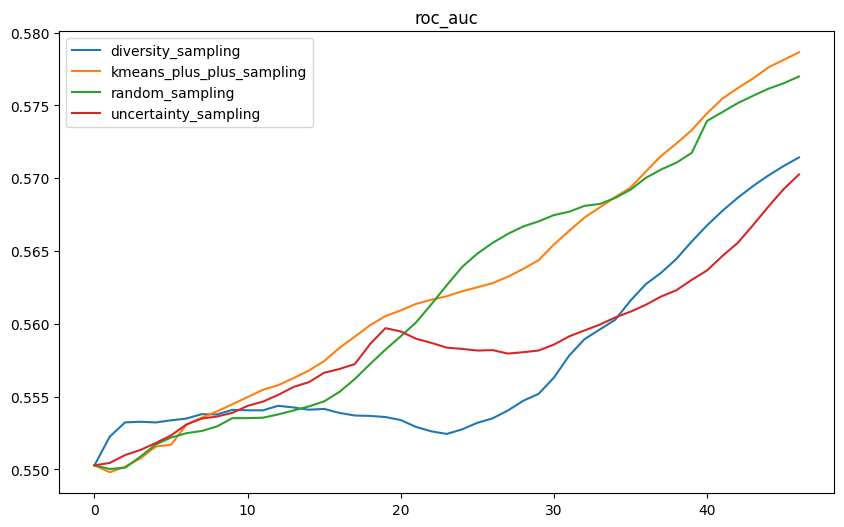

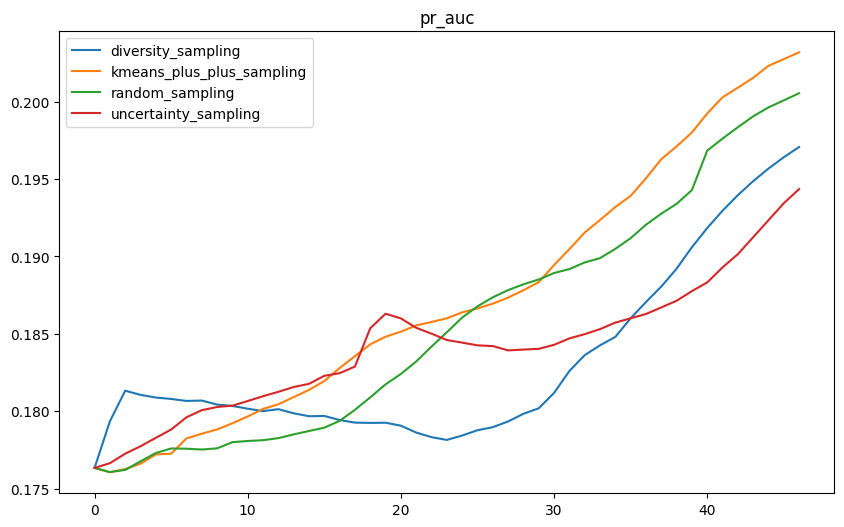

In [80]:
for metric in ["roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.9), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Aktywne uczenie z biblioteką modAL

In [71]:
import modAL
from modAL.models import ActiveLearner

In [72]:
mlearner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors=n_classes),
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train[initial_idx], y_training=y_train.values[initial_idx]
)
X_to_train = X_train.copy()
y_to_train = y_train.values.copy()
modAL_metrics = []

query_idx = initial_idx

for i in (t:= tqdm(range(n_iter))):
    mlearner.teach(X_to_train[query_idx], y_to_train[query_idx])

    X_to_train = np.delete(X_to_train, query_idx, axis=0)
    y_to_train = np.delete(y_to_train, query_idx, axis=0)
    y_pred = mlearner.predict(X_test)
    matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
    modAL_metrics.append({
        'default_metric': mlearner.score(X_test, y_test),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(matrix, matrix_pred),
        'pr_auc': average_precision_score(matrix, matrix_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })
    query_idx, query_inst = mlearner.query(X_to_train, n_instances=n_samples)

avg_loop_time = t.format_dict['elapsed']/ t.format_dict['total']
modAL_metrics = pd.DataFrame(modAL_metrics)
# modAL_metrics[["accuracy", "pr_auc", "roc_auc"]].plot()
# print(learner.score(X_test, y_test))

100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


In [73]:
f"One training loop with uncertainty_sampling from modAL takes approx. {round(avg_loop_time, 2)}s"

'One training loop with uncertainty_sampling from modAL takes approx. 0.43s'

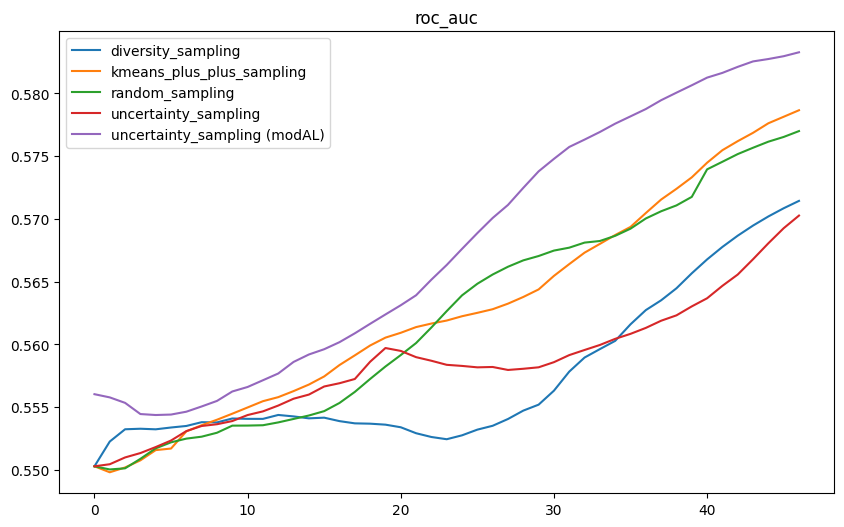

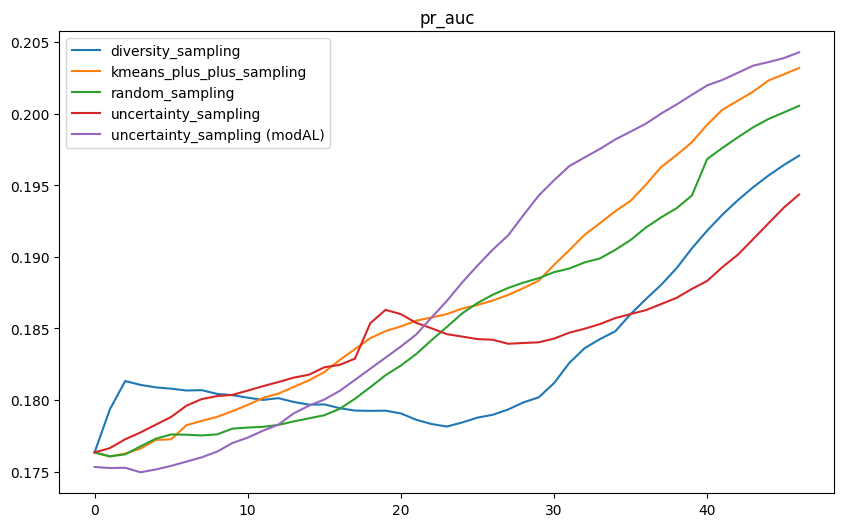

In [79]:
for metric in [ "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.9), label=f'{strategy}')
    ax.plot(modAL_metrics.index, smooth(modAL_metrics[metric], 0.9), label=f'uncertainty_sampling (modAL)')
    plt.legend()
    plt.title(metric)
    plt.show()

### Wnioski

Dla tego zbioru danych róznice między róznymi podejściami  do aktywnego uczenia są znacznie bardziej widoczne. Do połowy treningu metody aktywnego uczenia osiągają lepsze wyniki niż losowe wybieranie próbek. Można to tłumaczyć tym, że w pierwszej kolejności wybierane są próbki z mniejszych klas, co pozytywnie wpływa na jakość klasyfikacji modelu.

## Syntetyczny (sklearn.datasets.make_classification) / Klasyfikator SVM

### Zbiór danych

In [102]:
X,y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=6,
    n_classes=4,
    weights=[0.3,0.1,0.5,0.1],
    n_clusters_per_class=1,
    class_sep=1,
    hypercube=True,
    random_state=42)

In [103]:
from sklearn.decomposition import PCA

df = pd.DataFrame(X)
pcom = PCA(n_components=2).fit_transform(df)

<Axes: xlabel='X', ylabel='Y'>

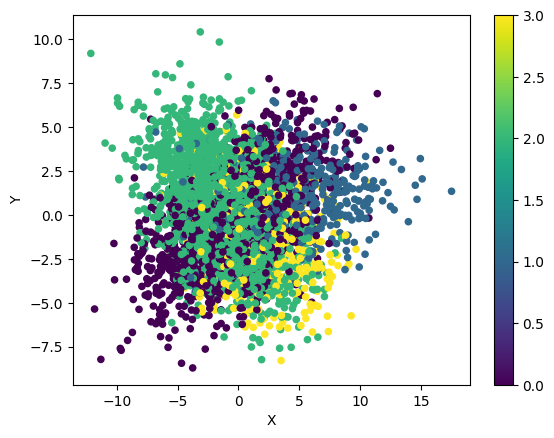

In [104]:
df = pd.concat([pd.DataFrame(pcom),pd.Series(y)], axis=1)
df.columns = ["X","Y","color"]
df.plot(kind='scatter', x="X",y="Y", color=df["color"], colormap='viridis')

### Wstępne przetwarzanie

In [105]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [107]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [108]:
t = SVC(probability=True, random_state=42)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [109]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [110]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.927, 'roc_auc': 0.927, 'pr_auc': 0.829}

### Aktywne uczenie

In [111]:
learner = ActiveModule(estimator=SVC,
                       X=X_train,
                       y_initial=y_train[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test,
                       probability=True,
                       random_state=42)

In [112]:
n_samples = 500
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [113]:
metrics, info = run_experiments(learner, y_train, [random_sampling, diversity_sampling, kmeans_plus_plus_sampling], n_samples, n_iter)

100%|██████████| 3/3 [11:48<00:00, 236.13s/it]


In [114]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.72s
One training loop with diversity_sampling takes approx. 86.57s
One training loop with kmeans_plus_plus_sampling takes approx. 1.26s


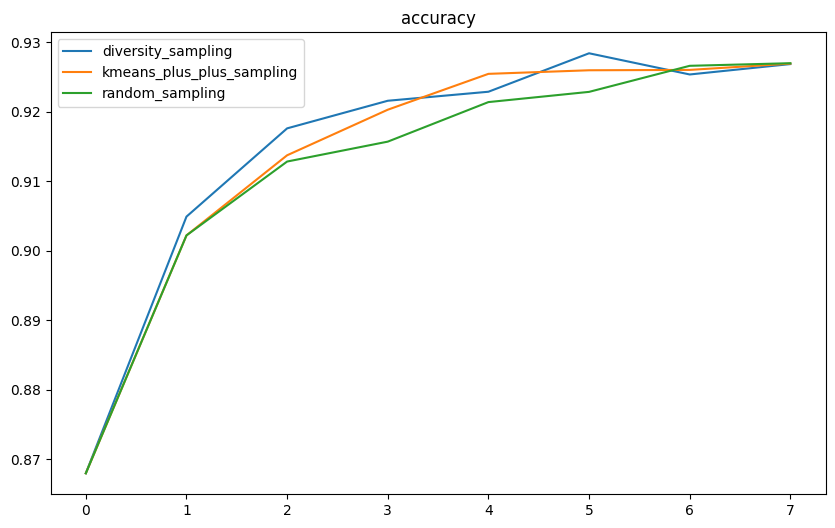

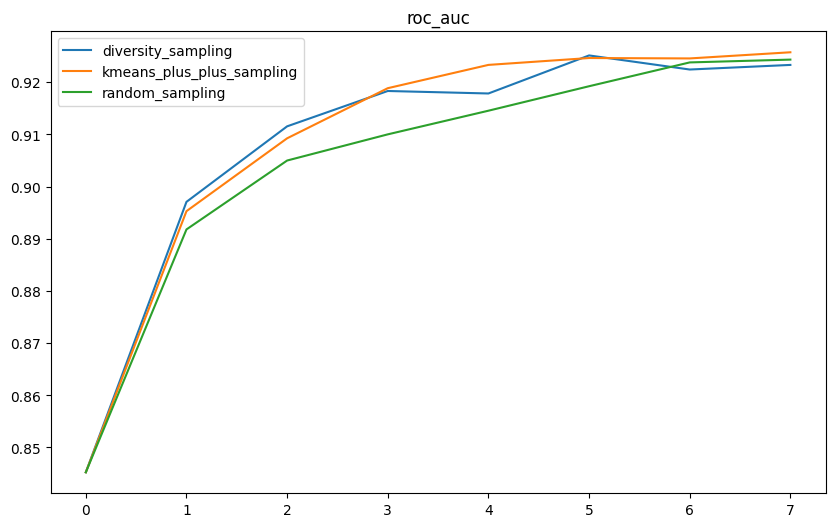

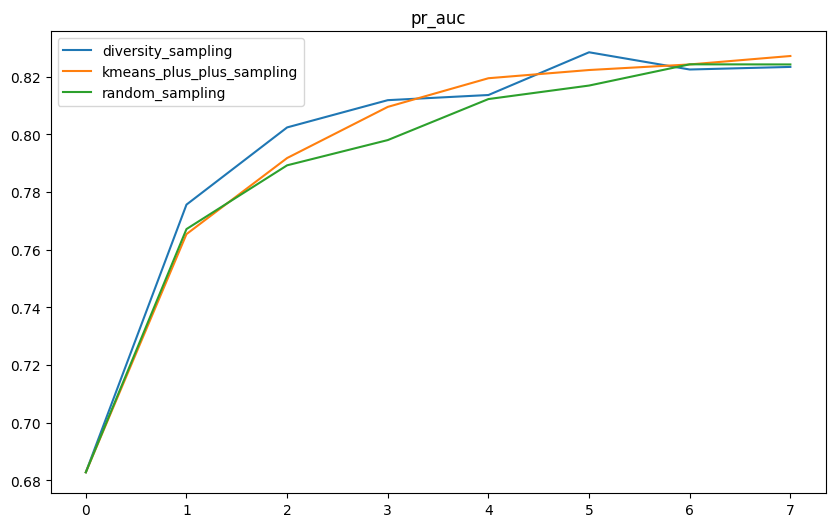

In [115]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.1), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Wnioski

Podobnie jak w poprzednim zbiorze danych, możemy zaobserwować różnicę między róznymi podejściami do aktywnego uczenia a losowym wyborem próbek. Na początku lepsze wyniki predykcji uzyskują metody wykorzystujące podejście aktywnego uczenia.

## Podsumowanie

Aktywne uczenie może zwiększyć skuteczność modeli klasyfikacji w warunkach ograniczonych danych treningowych. Metody stosujące niepewność modelu wymagają odpowiednio dużego i reprezentatywnego zbioru początkowego, na którym uczony będzie klasyfikator. W przypadku niespełnienia tych warunków aktywne uczenie może dawać wyniki nawet gorsze niż losowy wybór.
Metody maksymalizujące różnorodność wybieranych przykładów pozwalają osiągać lepze wyniki nawet przy zbiorze początkowym słabej jakości, jednak są one kosztowne obliczeniow i nie skalują się do większych zestawów danych.